- We will be using MovieLens dataset for training the recommendation model
- This dataset consists 100K movie ratings by users on a scale of 1-5

- We will focus on explicit feedback models - building a user-by-item-matrix. 

In [1]:
# !curl -O http://files.grouplens.org/datasets/movielens/ml-100k.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  4 4808k    4  196k    0     0  25096      0  0:03:16  0:00:08  0:03:08 41353^C


In [2]:
!unzip ml-100k.zip

Archive:  ml-100k.zip
  End-of-central-directory signature not found.  Either this file is not
  a zipfile, or it constitutes one disk of a multi-part archive.  In the
  latter case the central directory and zipfile comment will be found on
  the last disk(s) of this archive.
unzip:  cannot find zipfile directory in one of ml-100k.zip or
        ml-100k.zip.zip, and cannot find ml-100k.zip.ZIP, period.


In [3]:
import numpy as np
import pandas as pd

In [4]:
cd ml-100k/

/home/enosh/Documents/Canvas/4.2/Data Mining/RecommenderSystems_CF/bank/ml-100k


In [5]:
ls

allbut.pl*  u1.base  u2.test  u4.base  u5.test  ub.base  u.genre  u.occupation
mku.sh*     u1.test  u3.base  u4.test  ua.base  ub.test  u.info   u.user
README      u2.base  u3.test  u5.base  ua.test  u.data   u.item


In [6]:
!head u.data
!echo # line break
!wc -l u.data

196	242	3	881250949
186	302	3	891717742
22	377	1	878887116
244	51	2	880606923
166	346	1	886397596
298	474	4	884182806
115	265	2	881171488
253	465	5	891628467
305	451	3	886324817
6	86	3	883603013

100000 u.data


- We create the DF with the four neccessary column names

In [7]:
names = ['user_id', 'item_id', 'rating', 'timestamp']
df = pd.read_csv('u.data', sep='\t', names=names)
df.head()

,user_id,item_id,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


In [8]:
n_users = df.user_id.unique().shape[0]
n_items = df.item_id.unique().shape[0]
print (str(n_users) + ' users')
print (str(n_items) + ' items')

943 users
1682 items


- We need to construct our user-item matrix by removing the python offset between them
    - A user-item matrix maps out the ratings of the items per user

In [9]:
ratings = np.zeros((n_users, n_items))
for row in df.itertuples():
    ratings[row[1]-1, row[2]-1] = row[3]
ratings

array([[5., 3., 4., ..., 0., 0., 0.],
       [4., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [5., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 5., 0., ..., 0., 0., 0.]])

In [10]:
sparsity = float(len(ratings.nonzero()[0]))
sparsity /= (ratings.shape[0] * ratings.shape[1])
sparsity *= 100
print ('Sparsity: {:4.2f}%'.format(sparsity))

Sparsity: 6.30%


- From the dataset, 6.3% of the user-item ratings have values
    - at least every user has rated 20 movies, which explains the sparsity

- Train-test split on the user-item matrix above
    - We remove 10 ratings per user from the training set and place them in the test set

In [11]:
def train_test_split(ratings):
    test = np.zeros(ratings.shape)
    train = ratings.copy()
    for user in range(ratings.shape[0]):
        test_ratings = np.random.choice(ratings[user, :].nonzero()[0], 
                                        size=10, 
                                        replace=False)
        train[user, test_ratings] = 0.
        test[user, test_ratings] = ratings[user, test_ratings]
        
    # Test and training are truly disjoint
    assert(np.all((train * test) == 0)) 
    return train, test

In [12]:
train, test = train_test_split(ratings)

### Collaborative filtering model

- We measures the user or item similarity between any two pairs of users or items, respectively

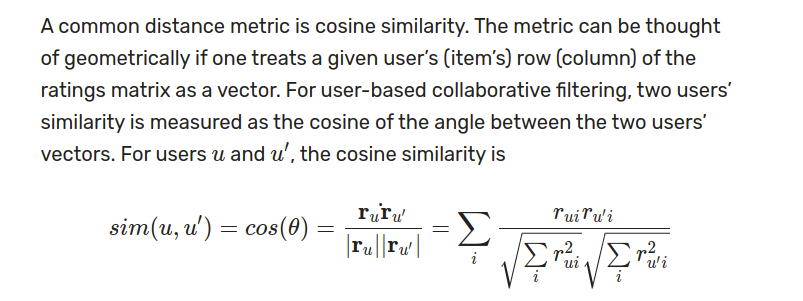

In [13]:
def slow_similarity(ratings, kind='user'):
    if kind == 'user':
        axmax = 0
        axmin = 1
    elif kind == 'item':
        axmax = 1
        axmin = 0
    sim = np.zeros((ratings.shape[axmax], ratings.shape[axmax]))
    for u in range(ratings.shape[axmax]):
        for uprime in range(ratings.shape[axmax]):
            rui_sqrd = 0.
            ruprimei_sqrd = 0.
            for i in range(ratings.shape[axmin]):
                sim[u, uprime] = ratings[u, i] * ratings[uprime, i]
                rui_sqrd += ratings[u, i] ** 2
                ruprimei_sqrd += ratings[uprime, i] ** 2
            sim[u, uprime] /= rui_sqrd * ruprimei_sqrd
    return sim

def fast_similarity(ratings, kind='user', epsilon=1e-9):
    # epsilon -> small number for handling dived-by-zero errors
    if kind == 'user':
        sim = ratings.dot(ratings.T) + epsilon
    elif kind == 'item':
        sim = ratings.T.dot(ratings) + epsilon
    norms = np.array([np.sqrt(np.diagonal(sim))])
    return (sim / norms / norms.T)

In [14]:
%timeit fast_similarity(train, kind='user')

21.3 ms ± 1.39 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [15]:
user_similarity = fast_similarity(train, kind='user')
item_similarity = fast_similarity(train, kind='item')
print (item_similarity[:4, :4])

[[1.         0.40445393 0.29901798 0.43737922]
 [0.40445393 1.         0.27206579 0.48851389]
 [0.29901798 0.27206579 1.         0.30930124]
 [0.43737922 0.48851389 0.30930124 1.        ]]


In [16]:
def predict_slow_simple(ratings, similarity, kind='user'):
    pred = np.zeros(ratings.shape)
    if kind == 'user':
        for i in range(ratings.shape[0]):
            for j in range(ratings.shape[1]):
                pred[i, j] = similarity[i, :].dot(ratings[:, j])\
                             /np.sum(np.abs(similarity[i, :]))
        return pred
    elif kind == 'item':
        for i in range(ratings.shape[0]):
            for j in range(ratings.shape[1]):
                pred[i, j] = similarity[j, :].dot(ratings[i, :].T)\
                             /np.sum(np.abs(similarity[j, :]))

        return pred

def predict_fast_simple(ratings, similarity, kind='user'):
    if kind == 'user':
        return similarity.dot(ratings) / np.array([np.abs(similarity).sum(axis=1)]).T
    elif kind == 'item':
        return ratings.dot(similarity) / np.array([np.abs(similarity).sum(axis=1)])

In [17]:
%timeit predict_slow_simple(train, user_similarity, kind='user')

15.9 s ± 1.17 s per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [18]:
%timeit predict_fast_simple(train, user_similarity, kind='user')

48.9 ms ± 5.99 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


- We’ll use the scikit-learn’s mean squared error function as our validation metric. Comparing user- and item-based collaborative filtering, it looks like user-based collaborative filtering gives us a better result.

In [19]:
from sklearn.metrics import mean_squared_error

def get_mse(pred, actual):
    # Ignore nonzero terms.
    pred = pred[actual.nonzero()].flatten()
    actual = actual[actual.nonzero()].flatten()
    return mean_squared_error(pred, actual)

In [20]:
item_prediction = predict_fast_simple(train, item_similarity, kind='item')
user_prediction = predict_fast_simple(train, user_similarity, kind='user')

In [21]:
print ('User-based CF MSE: ' + str(get_mse(user_prediction, test)))
print ('Item-based CF MSE: ' + str(get_mse(item_prediction, test)))

User-based CF MSE: 8.450829857805955
Item-based CF MSE: 11.495368431159731


- User-based CF gives better results, as the distance is the lowest with User-based filtering

- Top-K=k CF
    - Improving the prediction MSE by only considering the top k users who are most similar to the input user/item
    
    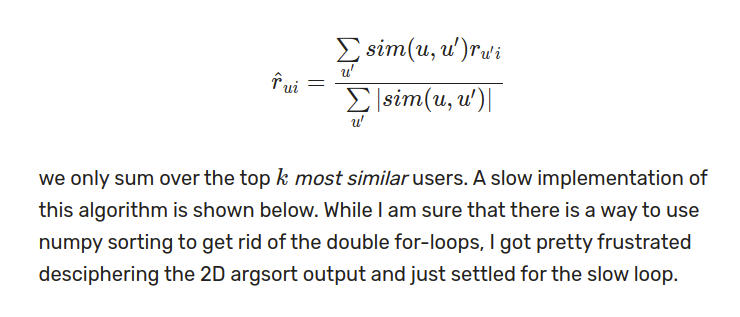

In [22]:
def predict_topk(ratings, similarity, kind='user', k=40):
    pred = np.zeros(ratings.shape)
    if kind == 'user':
        for i in range(ratings.shape[0]):
            top_k_users = [np.argsort(similarity[:,i])[:-k-1:-1]]
            for j in range(ratings.shape[1]):
                pred[i, j] = similarity[i, :][top_k_users].dot(ratings[:, j][top_k_users]) 
                pred[i, j] /= np.sum(np.abs(similarity[i, :][top_k_users]))
    if kind == 'item':
        for j in range(ratings.shape[1]):
            top_k_items = [np.argsort(similarity[:,j])[:-k-1:-1]]
            for i in range(ratings.shape[0]):
                pred[i, j] = similarity[j, :][top_k_items].dot(ratings[i, :][top_k_items].T) 
                pred[i, j] /= np.sum(np.abs(similarity[j, :][top_k_items]))        
    
    return pred

In [23]:
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

In [24]:
pred = predict_topk(train, user_similarity, kind='user', k=40)
print ('Top-k User-based CF MSE: ' + str(get_mse(pred, test)))

pred = predict_topk(train, item_similarity, kind='item', k=40)
print ('Top-k Item-based CF MSE: ' + str(get_mse(pred, test)))

Top-k User-based CF MSE: 6.551568479226485
Top-k Item-based CF MSE: 7.695315610982728


- Parameter(k) tuning 
    - to find the optimal  value for minimizing our testing MSE

In [25]:
k_array = [5, 15, 30, 50, 100, 200]
user_train_mse = []
user_test_mse = []
item_test_mse = []
item_train_mse = []

def get_mse(pred, actual):
    pred = pred[actual.nonzero()].flatten()
    actual = actual[actual.nonzero()].flatten()
    return mean_squared_error(pred, actual)

for k in k_array:
    user_pred = predict_topk(train, user_similarity, kind='user', k=k)
    item_pred = predict_topk(train, item_similarity, kind='item', k=k)
    
    user_train_mse += [get_mse(user_pred, train)]
    user_test_mse += [get_mse(user_pred, test)]
    
    item_train_mse += [get_mse(item_pred, train)]
    item_test_mse += [get_mse(item_pred, test)]  

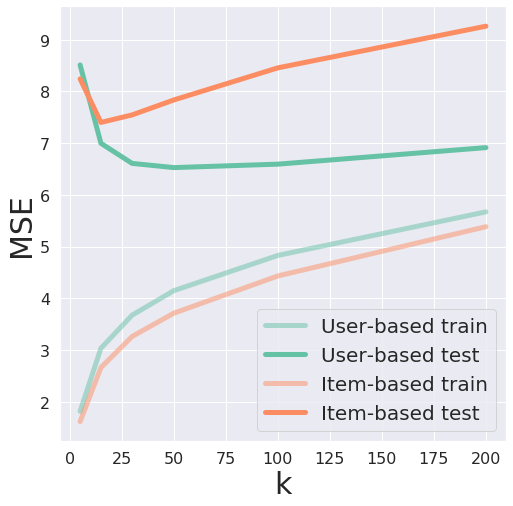

In [26]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

pal = sns.color_palette("Set2", 2)

plt.figure(figsize=(8, 8))
plt.plot(k_array, user_train_mse, c=pal[0], label='User-based train', alpha=0.5, linewidth=5)
plt.plot(k_array, user_test_mse, c=pal[0], label='User-based test', linewidth=5)
plt.plot(k_array, item_train_mse, c=pal[1], label='Item-based train', alpha=0.5, linewidth=5)
plt.plot(k_array, item_test_mse, c=pal[1], label='Item-based test', linewidth=5)
plt.legend(loc='best', fontsize=20)
plt.xticks(fontsize=16);
plt.yticks(fontsize=16);
plt.xlabel('k', fontsize=30);
plt.ylabel('MSE', fontsize=30);

- When the value of k is 50 and 15, a nice mininum is produced in the test error for user-and-item-based CF, respectively. 

In [27]:
!head -5 u.item

1|Toy Story (1995)|01-Jan-1995||http://us.imdb.com/M/title-exact?Toy%20Story%20(1995)|0|0|0|1|1|1|0|0|0|0|0|0|0|0|0|0|0|0|0
2|GoldenEye (1995)|01-Jan-1995||http://us.imdb.com/M/title-exact?GoldenEye%20(1995)|0|1|1|0|0|0|0|0|0|0|0|0|0|0|0|0|1|0|0
3|Four Rooms (1995)|01-Jan-1995||http://us.imdb.com/M/title-exact?Four%20Rooms%20(1995)|0|0|0|0|0|0|0|0|0|0|0|0|0|0|0|0|1|0|0
4|Get Shorty (1995)|01-Jan-1995||http://us.imdb.com/M/title-exact?Get%20Shorty%20(1995)|0|1|0|0|0|1|0|0|1|0|0|0|0|0|0|0|0|0|0
5|Copycat (1995)|01-Jan-1995||http://us.imdb.com/M/title-exact?Copycat%20(1995)|0|0|0|0|0|0|1|0|1|0|0|0|0|0|0|0|1|0|0
